[View in Colaboratory](https://colab.research.google.com/github/Bonnie970/SkienaAlgorithmDesign/blob/master/TensorFlowTutorial.ipynb)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [94]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [95]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [0]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

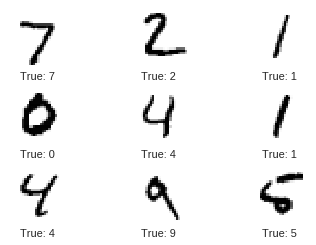

In [98]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [0]:

# We know that MNIST images are 28 pixels in each dimension.# We kn 
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [0]:
def new_weights(shape):
    # return A tensor of the specified shape filled with random truncated normal values
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
# wrap tf in a method to create covolutional layer 
def new_conv_layer(input,               # previous layer
                  num_input_channels,   # num. channels in prev. layer 
                  filter_size,          # width, height of each filter
                  num_filters,          # number of filter
                  use_pooling=True):    
  # shape of filter weight, defined by tensorflow
  shape = [filter_size, filter_size, num_input_channels, num_filters] 
  
  # create new weights
  weights = new_weights(shape=shape)
  
  # bias, one for each filter 
  biases = new_biases(length=num_filters)
  
  # strdies[0]: image number and [3]: image channel always set to 1
  # strides=[1, 2, 2, 1] would mean that the filter
  # is moved 2 pixels across the x- and y-axis of the image.
  layer = tf.nn.conv2d(input=input,
                      filter=weights,
                      strides=[1,1,1,1],
                      padding='SAME')
  
  layer += biases
  
  if use_pooling:
    layer = tf.nn.max_pool(value=layer,
                           ksize=[1,2,2,1],
                           strides=[1,2,2,1],
                           padding='SAME')
  
  # ReLU
  layer = tf.nn.relu(layer)
  
  return layer, weights

In [0]:
# reduce 4-dim conv layer to 2-dim input to FC layer
def flatten_layer(layer):
  # get shape of input layer
  # layer_shape == [num_images, img_height, img_width, num_channels]
  layer_shape = layer.get_shape()
  
  # The number of features is: img_height * img_width * num_channels
  # We can use a function from TensorFlow to calculate this.
  num_features = layer_shape[1:4].num_elements()
  
  # set the size of the second dimension
  # to num_features and the size of the first dimension to -1
  # which means the size in that dimension is calculated
  # so the total size of the tensor is unchanged from the reshaping.
  layer_flat = tf.reshape(layer, [-1, num_features])
  
  # The shape of the flattened layer is now:
  # [num_images, img_height * img_width * num_channels]

  # Return both the flattened layer and the number of features.
  return layer_flat, num_features

In [0]:
# input is a 2-dim tensor of shape [num_images, num_inputs]. 
# The output is a 2-dim tensor of shape [num_images, num_outputs]

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
  weights = new_weights(shape=[num_inputs, num_outputs])
  biases = new_biases(length=num_outputs)
  
  # Calculate the layer as the matrix multiplication of
  # the input and weights, and then add the bias-values.
  layer = tf.matmul(input, weights) + biases
  
  if use_relu:
    layer = tf.nn.relu(layer)
    
  return layer

In [0]:
# place holder 
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# The convolutional layers expect x to be encoded as a 4-dim tensor 
# reshape to [num_images, img_height, img_width, num_channels]
# Note that img_height == img_width == img_size 
# num_images can be inferred automatically by using -1 for the size of the first dimension
x_img = tf.reshape(x, [-1, img_size, img_size, num_channels])

# y size = num_image*10
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

In [0]:
# CONFIGURATION
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [0]:
# Conv 1 
conv1, weights_conv1 = new_conv_layer(input=x_img,               # previous layer
                                      num_input_channels=num_channels,   # num. channels in prev. layer 
                                      filter_size=filter_size1,          # width, height of each filter
                                      num_filters=num_filters1,          # number of filter
                                      use_pooling=True)

In [108]:
# it is the output of conv1 -- check shape
conv1

<tf.Tensor 'Relu_7:0' shape=(?, 14, 14, 16) dtype=float32>

In [109]:
int(conv1.shape[-1])

16

In [0]:
conv2, weights_conv2 = new_conv_layer(input=conv1,               # previous layer
                                      num_input_channels=int(conv1.shape[-1]),#num_filters1,   # num. channels in prev. layer 
                                      filter_size=filter_size2,          # width, height of each filter
                                      num_filters=num_filters2,          # number of filter
                                      use_pooling=True)

In [111]:
conv2

<tf.Tensor 'Relu_8:0' shape=(?, 7, 7, 36) dtype=float32>

In [0]:
# flat conv2, feed to fully-connected layer
conv2_flat, num_features = flatten_layer(conv2)

In [113]:
conv2_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

In [0]:
# FC layer1 
fc1 = new_fc_layer(input=conv2_flat,
              num_inputs=num_features,
              num_outputs=fc_size,
              use_relu=True)

In [0]:
# output layer
output = new_fc_layer(input=fc1,
              num_inputs=fc_size,
              num_outputs=num_classes,
              use_relu=True)

In [116]:
output

<tf.Tensor 'Relu_10:0' shape=(?, 10) dtype=float32>

In [0]:
# softmax -- regularization output class to between (0,1)
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cross entropy
cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, 
                                                       labels=y_true)
# In order to use the cross-entropy to guide the optimization of the model's 
# variables we need a single scalar value, so we simply take the average of 
# the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)


In [0]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [0]:
# performance measurement
# boolean vectore, 1 for correct
correct_pred = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Run TF

In [0]:
# create session
session = tf.Session()

# initial variables: weights and biases
session.run(tf.global_variables_initializer())

# batch size
batch_size = 64

total_iterations = 0 

def run(num_iterations):
  global total_iterations
  
  start_time = time.time()
  
  for i in range(total_iterations,
                   total_iterations + num_iterations):
    x_batch, y_true_batch = data.train.next_batch(batch_size)
    # Put the batch into a dict with the proper names
    # for placeholder variables in the TensorFlow graph.
    feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
    
    # Run the optimizer using this batch of training data.
    # TensorFlow assigns the variables in feed_dict_train
    # to the placeholder variables and then runs the optimizer.
    session.run(optimizer, feed_dict=feed_dict_train)
    
    # Print status every 100 iterations.
    if i % 100 == 0:
        # Calculate the accuracy on the training-set.
        acc = session.run(accuracy, feed_dict=feed_dict_train)

        # Message for printing.
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

        # Print it.
        print(msg.format(i + 1, acc))
  
  total_iterations += num_iterations

  end_time = time.time()
  time_dif = end_time - start_time
  print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [122]:
run(1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [123]:
run(100)

Optimization Iteration:    101, Training Accuracy:  67.2%
Time usage: 0:00:01


In [124]:
run(1899)

Optimization Iteration:    201, Training Accuracy:  71.9%
Optimization Iteration:    301, Training Accuracy:  70.3%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  82.8%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  85.9%
Optimization Iteration:    901, Training Accuracy:  85.9%
Optimization Iteration:   1001, Training Accuracy:  90.6%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1601, Training Accuracy:  92.2%
Optimization Iteration:   1701, Training Accuracy:  89.1%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization I

In [125]:
weights_conv1[:,:,0,0]

<tf.Tensor 'strided_slice_3:0' shape=(5, 5) dtype=float32>

In [0]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

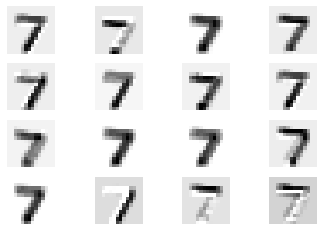

In [127]:
image = data.test.images[0]
plot_conv_layer(conv1, image)

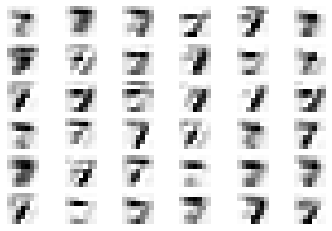

In [128]:
plot_conv_layer(conv2, image)

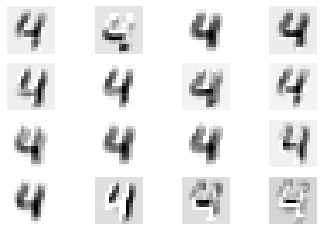

In [129]:
image = data.test.images[4]
plot_conv_layer(conv1, image)

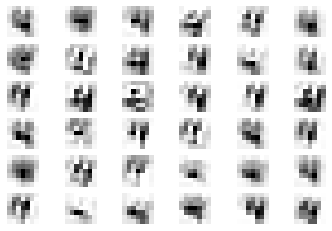

In [130]:
plot_conv_layer(conv2, image)

In [0]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

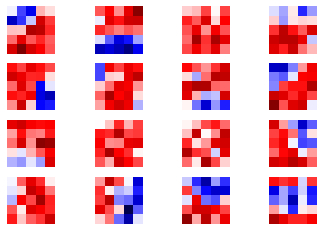

In [132]:
plot_conv_weights(weights_conv1, input_channel=0)

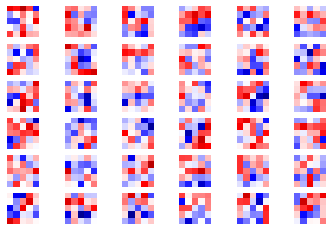

In [133]:
plot_conv_weights(weights_conv2, input_channel=0)

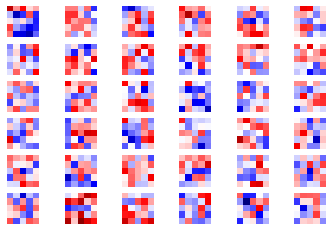

In [134]:
# there are 16 channels in total
plot_conv_weights(weights_conv2, input_channel=15)

In [135]:
total_iterations

2000

In [0]:
# session.close()